In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, log_loss, confusion_matrix
from xgboost import XGBClassifier

1. обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта
2. при обучении моделей обязательно использовать кроссвалидацию
3. вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)
4. сделать выводы о том, какая модель справилась с задачей лучше других
5. (опциональный вопрос) какая метрика (precision_recall_curve или roc_auc_curve) больше подходит в случае сильного дисбаланса классов? (когда объектов одного из классов намного больше чем другого). 

p.s.В вопросе проще разобраться, если вспомнить оси на графике roc auc curve и рассмотреть такой пример:

Имеется 100000 объектов, из которых только 100 - класс "1" (99900 - класс "0", соответственно). 
Допустим, у нас две модели:

- первая помечает 100 объектов как класс 1, но TP = 90
- вторая помечает 1000 объектов как класс 1, но TP такой же - 90

Какая модель лучше и почему? И что позволяет легче сделать вывод - roc_auc_curve или precision_recall_curve?

In [2]:
path = '/home/arthur/Project/GeekBrains/ML-in-business/!ADDS/lection3_materials/train_case2.csv'

In [3]:
df = pd.read_csv(path, sep=';')
df.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


In [4]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1), 
                                                    df['cardio'], random_state=0)

Трансформируем колонки в Pipeline'ах  
К полям:
- gender, cholesterol применим OHE-кодирование
- age, height, weight, ap_hi, ap_lo - standardScaler
- gluc, smoke, alco, active - оставим пока как есть

In [5]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame 
    to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame 
    to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]

In [6]:
continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                            ('selector', NumberSelector(key=cont_col)),
                            ('standard', StandardScaler())
                            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                                ('selector', ColumnSelector(key=cat_col)),
                                ('ohe', OHEEncoder(key=cat_col))
                                ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                                ('selector', NumberSelector(key=base_col))
                                ])
    base_transformers.append((base_col, base_transformer))

Теперь объединим все наши трансформеры с помощью FeatureUnion и заупстим трансформацию

In [7]:
feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[-1.73391771,  0.6873301 ,  0.74843904, ...,  1.        ,
         0.        ,  1.        ],
       [-1.67343538,  0.07758923, -0.29640123, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.13738132,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.17775864,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  1.        ],
       [-0.47190715, -1.38578883,  0.74843904, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.38174619,  0.56538192, -0.08743318, ...,  0.        ,
         0.        ,  1.        ]])

Посчитаем precision/recall/f_score/roc_auc

In [8]:
def get_scores(y_true, 
               y_predicted, 
               f_score_b=1, 
               title='Confusion matrix', 
               classes=['cardio_0', 'cardio_1'], 
               normalize=False):
    """
    calculate:
    - precision
    - recall
    - fscore
    - roc-auc
    - confusion matrix
    """
    precision, recall, thresholds = precision_recall_curve(y_true, y_predicted)
    fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    roc_auc = roc_auc_score(y_true, y_predicted)
    log_loss_score = log_loss(y_true, y_predicted)
    
    cm = confusion_matrix(y_true, y_predicted>thresholds[ix])
    TN = cm[0][0]
    FN = cm[1][0]
    TP = cm[1][1]
    FP = cm[0][1]
    TPR = TP/(TP+FN)
    FPR = FP/(FP+TN)
    TNR = TN/(FP+TN)
    print(f'\
Precision = {precision[ix]:.3f}\n\
Recall    = {recall[ix]:.3f}\n\
F-score   = {fscore[ix]:.3f}\n\
ROC_AUC   = {roc_auc:.3f}\n\
Log_loss  = {log_loss_score:.3f}\n\
True_pos  = {TPR:.3f}\n\
False_pos = {FPR:.3f}\n\
True_neg  = {TNR:.3f}\n')

    sns.set(font_scale=1.5)
    sns.set_color_codes("muted")

    plt.figure(figsize=(10, 8))
    fpr, tpr, thresholds_ = roc_curve(y_true, y_predicted, pos_label=1)
    lw = 2
    plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.show()
    
    font = {'size' : 15}
    plt.rc('font', **font)
    plt.figure(figsize=(10, 8))
    cmap=plt.cm.Blues
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    return {
            'Precision': precision[ix],
            'Recall': recall[ix],
            'F-score': fscore[ix],
            'ROC_AUC': roc_auc,
            'Log_loss': log_loss_score,
            'True_pos': TPR,
            'False_pos': FPR,
            'True_neg': TNR
            }

Основной цикл обучения моделей

In [9]:
%%time
n_estimators = 10
classifier = Pipeline([
    ('features', feats),
#     ('classifier', GradientBoostingClassifier(n_estimators, random_state = 42)),
    ('classifier', RandomForestClassifier(n_estimators, random_state = 42))
])


# #запустим кросс-валидацию
# cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')
# cv_score = np.mean(cv_scores)
# cv_score_std = np.std(cv_scores)
# print('CV score is {}+-{}'.format(round(cv_score, 3), round(cv_score_std,3)))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]
print('mean y_score is  {}'.format(round(np.mean(y_score), 3)))

mean y_score is  0.497
CPU times: user 423 ms, sys: 7.32 ms, total: 430 ms
Wall time: 429 ms


/home/arthur/anaconda3/lib/python3.7/site-packages/xgboost/core.py:430: FutureWarning: Pass `objective` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  format(", ".join(args_msg)), FutureWarning)


LogisticRegression
Наилучшие параметры {'C': 0.001, 'penalty': 'l2'}
mean y_score is  0.457
Precision = 0.709
Recall    = 0.653
F-score   = 0.680
ROC_AUC   = 0.694
Log_loss  = 10.545
True_pos  = 0.000
False_pos = 0.000
True_neg  = 1.000



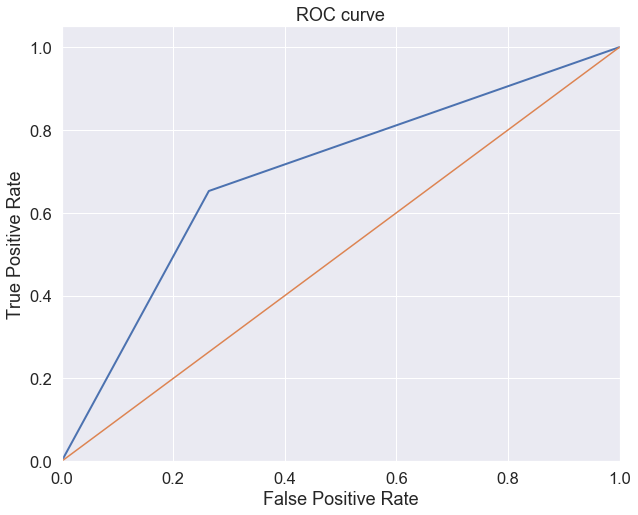

Confusion matrix, without normalization
[[8820    0]
 [8680    0]]


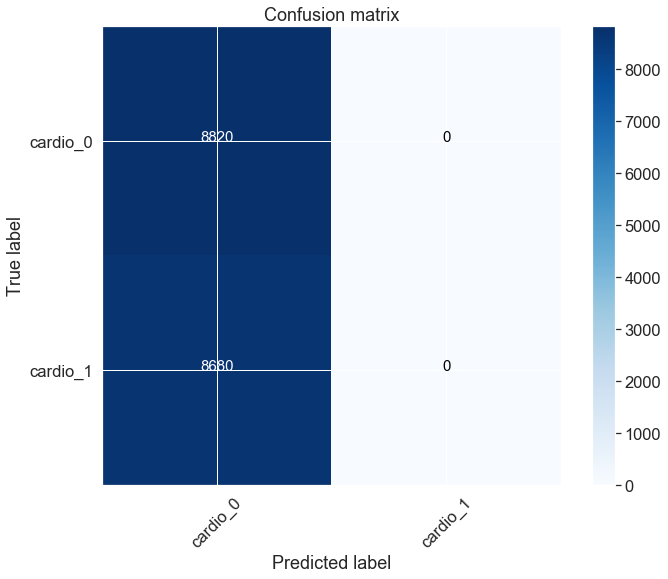

----------------------------------------------------------------------------
RandomForestClassifier
Наилучшие параметры {'max_depth': 10, 'n_estimators': 200}
mean y_score is  0.442
Precision = 0.761
Recall    = 0.678
F-score   = 0.717
ROC_AUC   = 0.734
Log_loss  = 9.160
True_pos  = 0.000
False_pos = 0.000
True_neg  = 1.000



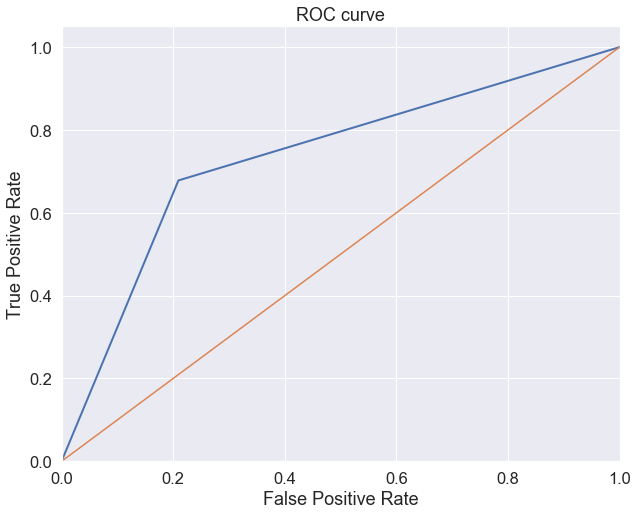

Confusion matrix, without normalization
[[8820    0]
 [8680    0]]


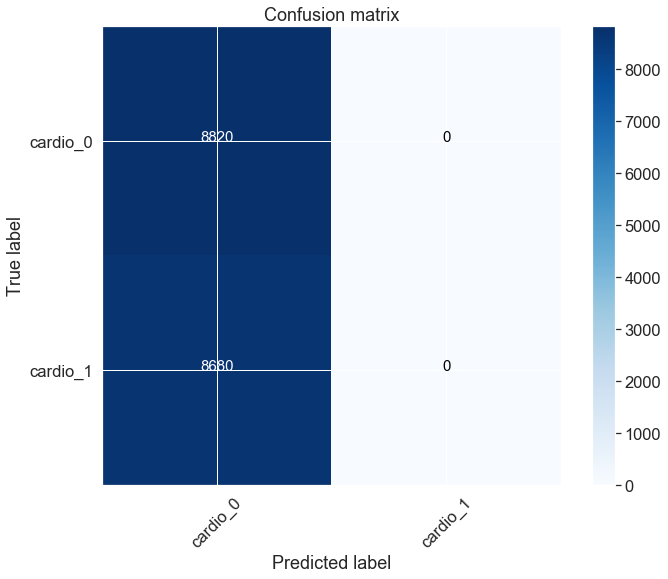

----------------------------------------------------------------------------
GradientBoostingClassifier


ValueError: Unknown format code 's' for object of type 'int'

In [12]:
%%time
random_state = 42
b = 1
results = {}
models_names = ['LogisticRegression', 
                'RandomForestClassifier',
                'GradientBoostingClassifier',
                'XGBClassifier']
for i, model in enumerate([LogisticRegression(random_state),
                           RandomForestClassifier(random_state),
                           GradientBoostingClassifier(random_state),
                           XGBClassifier(random_state)]):
    print(models_names[i])
    classifier = Pipeline([
                          ('features', feats),
                          ('classifier', model)
                          ])
    # узнаем какие гиперпараметры для леса дадут наилучший результат (кроссвалидация - KFold)
    if i == 0:
        params = {"C":np.logspace(-3,3,7), 
                  "penalty":["l1","l2"]}  # l1 lasso l2 ridge
    else:
        params = {'n_estimators':[10, 50, 100, 200], 
                  'max_depth':[2, 5, 7, 10]}
    gs = GridSearchCV(model, 
                      params, 
                      scoring='r2', 
                      cv=KFold(n_splits=3, random_state=42, shuffle=True), 
                      n_jobs=-1)
    gs.fit(X_train, y_train)
    # наилучшие параметры:
    print('Наилучшие параметры', gs.best_params_)
    y_score = gs.predict(X_test)
    print('mean y_score is  {}'.format(round(np.mean(y_score), 3)))
    results[models_names[i]] = [y_score, get_scores(y_test, y_score)]
    print('----------------------------------------------------------------------------')

In [11]:
raise 0

TypeError: exceptions must derive from BaseException

In [ ]:
# Define a function that compares all final models
def final_comparison(models, test_features, test_labels):
    scores = pd.DataFrame()
    for model in models:
        predictions = model.predict(test_features)
        mae = round(mean_absolute_error(test_labels, predictions), 4)
        mse = round(mean_squared_error(test_labels, predictions), 4)
        r2 = round(r2_score(test_labels, predictions), 4)
        errors = abs(predictions - test_labels)
        mape = 100 * np.mean(errors / test_labels)
        accuracy = round(100 - mape, 4)
        scores[str(model)] = [mae, mse, r2, accuracy]
    scores.index = ['Mean Absolute Error', 'Mean Squared Error', 'R^2', 'Accuracy']
    return scores

In [ ]:
final_scores = final_comparison([mlr_final, rf_final, xgb_final], X_test, y_test)

# Adjust the column headers
final_scores.columns  = ['Linear Regression', 'Random Forest', 'Extreme Gradient Boosting']